<a href="https://colab.research.google.com/github/myndaaa/Natural-Language-Processing/blob/main/FNLP_Tutorial9_Question_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**COS30081 FNLP Tutorial 9: BERT**

##**Lab Task Submission at bottom #PassTask8**
## **Name:**
## **Student ID:**

# Lab Submission 8 (Due Sunday Week 10, 11:59 PM)

1. Adapt the code from the BERT tutorial to try different models. **The goal is just to classify positive and negative sentiments.** T

Use the same dataset


Compulsory tasks
*   Utilise at least three different pretrained networks
*   Compare the accuracies/loss and pinpoint the best model you've tried

**Optional tasks:**
*   Try out different datasets to be familiar with the variables and pipeline

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

In [2]:
!pip install "tf-models-official==2.13.*"

  Using cached tf_models_official-2.13.2-py2.py3-none-any.whl (2.6 MB)
  Using cached immutabledict-4.2.0-py3-none-any.whl (4.7 kB)
  Using cached sacrebleu-2.4.2-py3-none-any.whl (106 kB)
  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=d92945129e5a71905ec24e53d315c760f1a00ff91186f81340194abc08ae8562
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import official.nlp.optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 3s 0us/step


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


model 1

In [6]:
b_model = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
b_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


model 2

In [7]:
b_model2 = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1'
b_preprocess2 = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

model 3

In [21]:
b_model3 = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1'
b_preprocess3 = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [9]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(b_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(b_model, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [10]:

classifier_model = build_classifier_model()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [11]:
init_lr = 3e-5
optimizer = official.nlp.optimization.create_optimizer(
  init_lr=init_lr,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  optimizer_type='adamw')

classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history = classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
625/625 [==============================] - 315s 498ms/step - loss: 0.6461 - binary_accuracy: 0.5940 - val_loss: 0.5344 - val_binary_accuracy: 0.6922
Epoch 2/5
625/625 [==============================] - 308s 494ms/step - loss: 0.4935 - binary_accuracy: 0.7503 - val_loss: 0.4638 - val_binary_accuracy: 0.7532
Epoch 3/5
625/625 [==============================] - 306s 490ms/step - loss: 0.4393 - binary_accuracy: 0.7894 - val_loss: 0.4408 - val_binary_accuracy: 0.7802
Epoch 4/5
625/625 [==============================] - 318s 509ms/step - loss: 0.4133 - binary_accuracy: 0.8065 - val_loss: 0.4404 - val_binary_accuracy: 0.7812
Epoch 5/5
625/625 [==============================] - 309s 494ms/step - loss: 0.4006 - binary_accuracy: 0.8135 - val_loss: 0.4390 - val_binary_accuracy: 0.7822


In [12]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 108s 138ms/step - loss: 0.4389 - binary_accuracy: 0.7848
Loss: 0.4389350414276123
Accuracy: 0.7847999930381775


History keys: dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Training and Validation Accuracy and Loss per Epoch:
Epoch 1
Training accuracy: 0.5940499901771545, Validation accuracy: 0.6922000050544739
Training loss: 0.6460807919502258, Validation loss: 0.5343888401985168
------------------------------
Epoch 2
Training accuracy: 0.7502999901771545, Validation accuracy: 0.7531999945640564
Training loss: 0.49350351095199585, Validation loss: 0.4637705087661743
------------------------------
Epoch 3
Training accuracy: 0.7893999814987183, Validation accuracy: 0.7802000045776367
Training loss: 0.4393403232097626, Validation loss: 0.4407944679260254
------------------------------
Epoch 4
Training accuracy: 0.8065000176429749, Validation accuracy: 0.7811999917030334
Training loss: 0.41325390338897705, Validation loss: 0.44039884209632874
------------------------------
Epoch 5
Training accuracy: 0.8134999871253967, Validation accuracy: 0.7821999788284302
Training los

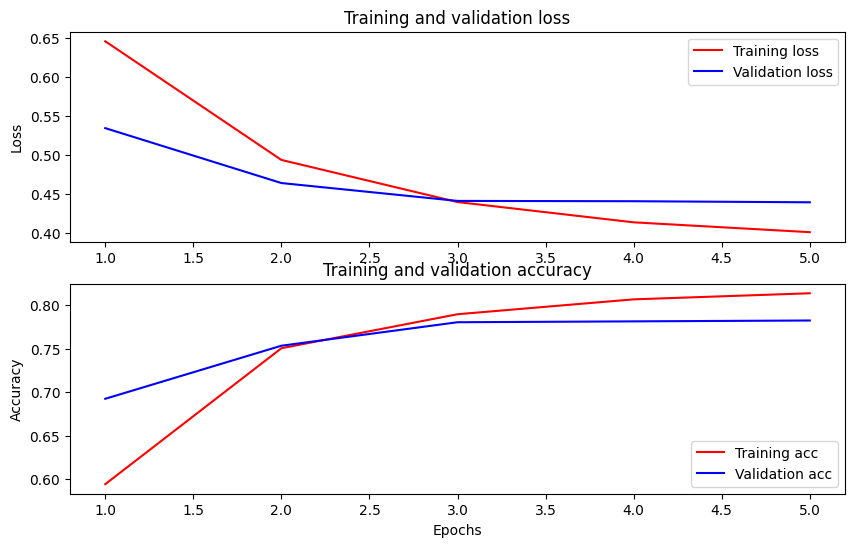

In [13]:
history_dict = history.history

# Printing the keys
print("History keys:", history_dict.keys())

# Extracting the relevant data
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Printing out the accuracy and loss for training and validation
print("\nTraining and Validation Accuracy and Loss per Epoch:")
for epoch in range(len(acc)):
    print(f"Epoch {epoch + 1}")
    print(f"Training accuracy: {acc[epoch]}, Validation accuracy: {val_acc[epoch]}")
    print(f"Training loss: {loss[epoch]}, Validation loss: {val_loss[epoch]}")
    print("-" * 30)

# Creating the plot
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

# Plotting training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [14]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(b_preprocess2, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(b_model2, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [15]:
classifier_model = build_classifier_model()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [16]:
init_lr = 3e-5
optimizer = official.nlp.optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 831s 1s/step - loss: 0.5707 - binary_accuracy: 0.6729 - val_loss: 0.4446 - val_binary_accuracy: 0.7854
Epoch 2/5
625/625 [==============================] - 818s 1s/step - loss: 0.4253 - binary_accuracy: 0.7946 - val_loss: 0.4144 - val_binary_accuracy: 0.8074
Epoch 3/5
625/625 [==============================] - 809s 1s/step - loss: 0.3799 - binary_accuracy: 0.8231 - val_loss: 0.4093 - val_binary_accuracy: 0.8118
Epoch 4/5
625/625 [==============================] - 811s 1s/step - loss: 0.3502 - binary_accuracy: 0.8407 - val_loss: 0.4158 - val_binary_accuracy: 0.8202
Epoch 5/5
625/625 [==============================] - 809s 1s/step - loss: 0.3306 - binary_accuracy: 0.8530 - val_loss: 0.4196 - val_binary_accuracy: 0.8176


In [17]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 255s 326ms/step - loss: 0.4104 - binary_accuracy: 0.8213
Loss: 0.4103873372077942
Accuracy: 0.8213199973106384


History keys: dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Training and Validation Accuracy and Loss per Epoch:
Epoch 1
Training accuracy: 0.6729000210762024, Validation accuracy: 0.7853999733924866
Training loss: 0.5706633925437927, Validation loss: 0.4446074664592743
------------------------------
Epoch 2
Training accuracy: 0.7945500016212463, Validation accuracy: 0.8073999881744385
Training loss: 0.42526426911354065, Validation loss: 0.4143562912940979
------------------------------
Epoch 3
Training accuracy: 0.8231499791145325, Validation accuracy: 0.8118000030517578
Training loss: 0.3799281716346741, Validation loss: 0.4092971384525299
------------------------------
Epoch 4
Training accuracy: 0.840749979019165, Validation accuracy: 0.8202000260353088
Training loss: 0.35018041729927063, Validation loss: 0.41583406925201416
------------------------------
Epoch 5
Training accuracy: 0.8530499935150146, Validation accuracy: 0.8176000118255615
Training loss

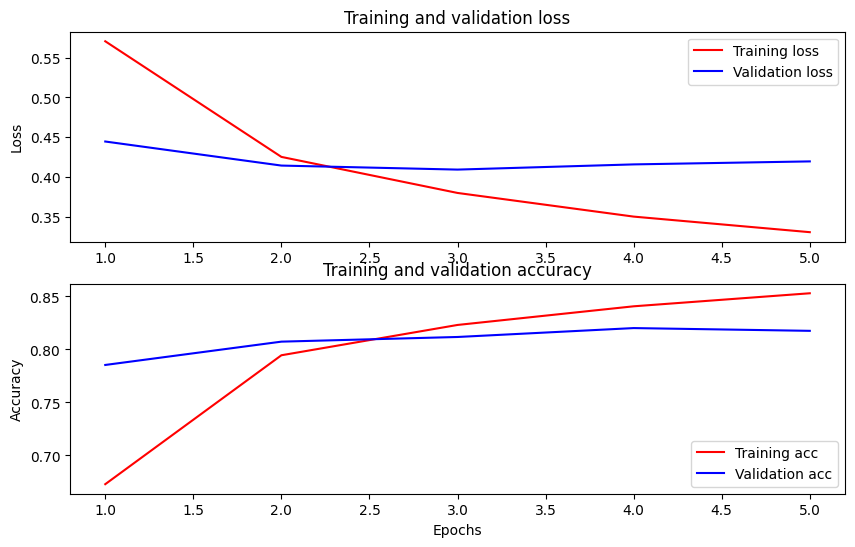

In [18]:
history_dict = history.history

# Printing the keys
print("History keys:", history_dict.keys())

# Extracting the relevant data
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Printing out the accuracy and loss for training and validation
print("\nTraining and Validation Accuracy and Loss per Epoch:")
for epoch in range(len(acc)):
    print(f"Epoch {epoch + 1}")
    print(f"Training accuracy: {acc[epoch]}, Validation accuracy: {val_acc[epoch]}")
    print(f"Training loss: {loss[epoch]}, Validation loss: {val_loss[epoch]}")
    print("-" * 30)

# Creating the plot
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

# Plotting training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [19]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(b_preprocess3, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(b_model3, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [22]:
#hyperparameters
classifier_model = build_classifier_model()

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [23]:
init_lr = 3e-5
optimizer = official.nlp.optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')

classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history = classifier_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
625/625 [==============================] - 573s 906ms/step - loss: 0.6156 - binary_accuracy: 0.6411 - val_loss: 0.4718 - val_binary_accuracy: 0.7536
Epoch 2/5
625/625 [==============================] - 555s 888ms/step - loss: 0.4551 - binary_accuracy: 0.7766 - val_loss: 0.4340 - val_binary_accuracy: 0.7852
Epoch 3/5
625/625 [==============================] - 558s 894ms/step - loss: 0.4147 - binary_accuracy: 0.8046 - val_loss: 0.4238 - val_binary_accuracy: 0.7988
Epoch 4/5
625/625 [==============================] - 559s 894ms/step - loss: 0.3882 - binary_accuracy: 0.8190 - val_loss: 0.4253 - val_binary_accuracy: 0.8050
Epoch 5/5
625/625 [==============================] - 560s 897ms/step - loss: 0.3786 - binary_accuracy: 0.8260 - val_loss: 0.4251 - val_binary_accuracy: 0.8018


In [24]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 183s 234ms/step - loss: 0.4229 - binary_accuracy: 0.8084
Loss: 0.42294883728027344
Accuracy: 0.8083999752998352


History keys: dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Training and Validation Accuracy and Loss per Epoch:
Epoch 1
Training accuracy: 0.6410999894142151, Validation accuracy: 0.753600001335144
Training loss: 0.6155598759651184, Validation loss: 0.47181054949760437
------------------------------
Epoch 2
Training accuracy: 0.7766000032424927, Validation accuracy: 0.7851999998092651
Training loss: 0.455060750246048, Validation loss: 0.43399757146835327
------------------------------
Epoch 3
Training accuracy: 0.8046000003814697, Validation accuracy: 0.798799991607666
Training loss: 0.41470804810523987, Validation loss: 0.42375287413597107
------------------------------
Epoch 4
Training accuracy: 0.8190000057220459, Validation accuracy: 0.8050000071525574
Training loss: 0.3882121741771698, Validation loss: 0.42525947093963623
------------------------------
Epoch 5
Training accuracy: 0.8260499835014343, Validation accuracy: 0.801800012588501
Training loss:

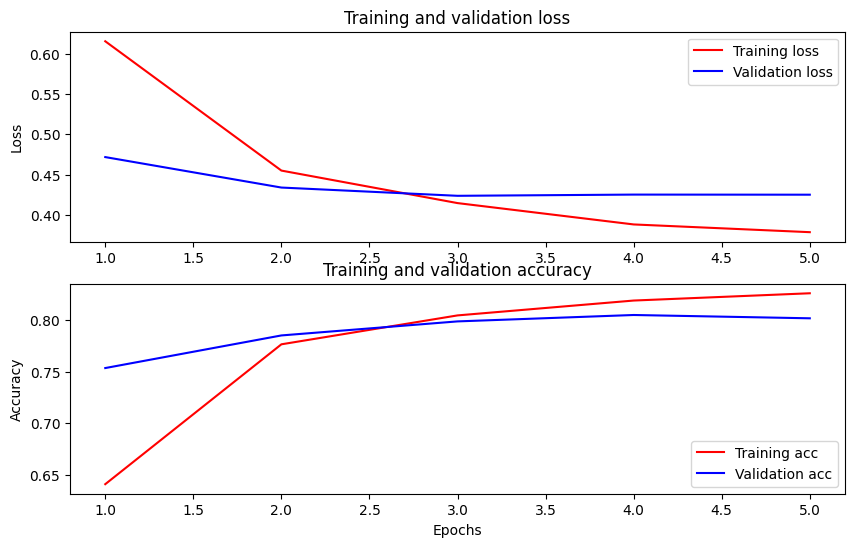

In [25]:
history_dict = history.history

# Printing the keys
print("History keys:", history_dict.keys())

# Extracting the relevant data
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Printing out the accuracy and loss for training and validation
print("\nTraining and Validation Accuracy and Loss per Epoch:")
for epoch in range(len(acc)):
    print(f"Epoch {epoch + 1}")
    print(f"Training accuracy: {acc[epoch]}, Validation accuracy: {val_acc[epoch]}")
    print(f"Training loss: {loss[epoch]}, Validation loss: {val_loss[epoch]}")
    print("-" * 30)

# Creating the plot
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

# Plotting training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Thoughts


> Comparing the three models based on training and validation accuracy and loss over five epochs, the second model outperforms the others. The second model achieved the highest validation accuracy (81.8%) and consistently lower validation losses, indicating better generalization. The first model showed decent improvement, but its validation accuracy plateaued around 78.2%. The third model improved steadily but did not surpass the second model's performance. The second model's superior initial accuracy and sustained improvement in both metrics make it the best among the three for this task.

---

☕
